In [111]:
import pandas as pd

df = pd.read_csv(
'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None) #The wine dataset


df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash','Alcalinity of ash', 'Magnesium','Total phenols', 'Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

display(df.groupby('Class label').size())

,0
Class label,
1,59
2,71
3,48


# **`RobustScaler` when there are outliers. `StandardScaler` if no outlier is confirmend. If unsure about outliers, use both**

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.multiclass import OneVsRestClassifier

X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

lr = OneVsRestClassifier(LogisticRegression(penalty='l1', solver='liblinear', random_state=0, C=1))

rbsc = RobustScaler()

X_train_std = rbsc.fit_transform(X_train)
X_test_std = rbsc.transform(X_test)

lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))


Training accuracy: 1.0
Test accuracy: 1.0


In [113]:
for i, estimator in enumerate(lr.estimators_):
    print(f'Intercept for class {lr.classes_[i]}: {estimator.intercept_}')

print('\n')

for i, estimator in enumerate(lr.estimators_):
    print(f'Intercept for class {lr.classes_[i]}: {estimator.coef_}')


Intercept for class 1: [-1.39557714]
Intercept for class 2: [-0.13119012]
Intercept for class 3: [-2.758704]


Intercept for class 1: [[ 1.81005948  0.          0.8676431  -1.3173833   0.          0.
   1.54300452  0.          0.          0.          0.          0.92606452
   3.23838548]]
Intercept for class 2: [[-1.86081106 -0.72424286 -1.02474931  0.45665227 -0.11942702  0.
   0.93674546  0.          0.         -2.69604418  1.13821937  0.
  -3.20485893]]
Intercept for class 3: [[ 0.          0.13278812  0.29760966  0.          0.          0.
  -3.77816112  0.         -0.02092783  1.87850459 -1.20945617 -0.35921255
   0.        ]]


# **Watching how value of C (inversely proportional to the tightness of regularization) changes the coefs**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

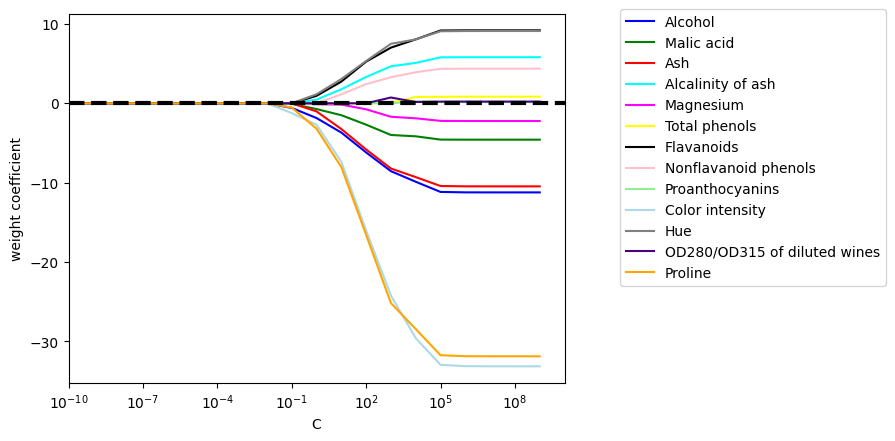

In [114]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']

weights, params = [], []

for c in np.arange(-10., 10.):
  lr = LogisticRegression(penalty='l1', C=10.**c,
  solver='liblinear',
  multi_class='ovr', random_state=0)
  lr.fit(X_train_std, y_train)
  weights.append(lr.coef_[1])
  params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
  plt.plot(params, weights[:, column],

label=df.columns[column + 1], color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-10), 10**10])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')

ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)

plt.show()

# **Sequential Back Selection (SBS) aka Backward Eliminaion for feature selection**

In [115]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):
              score = self._calc_score(X_train, y_train, X_test, y_test, p)
              scores.append(score)
              subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])

        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [116]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

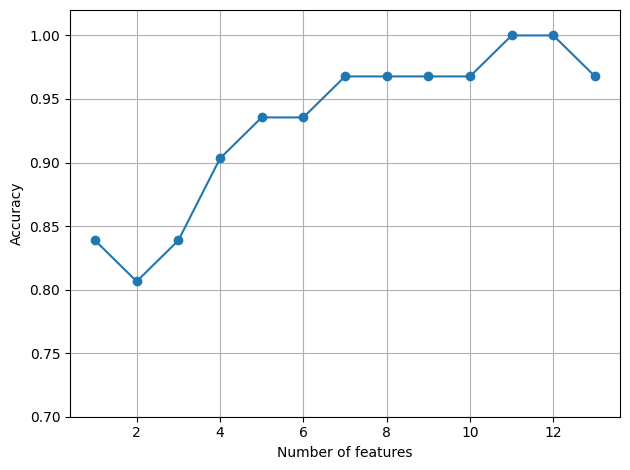

In [117]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()

plt.show()

In [118]:
k3 = list(sbs.subsets_[10])
print(df.columns[1:][k3])


Index(['Alcohol', 'Nonflavanoid phenols', 'Color intensity'], dtype='object')


In [119]:
knn.fit(X_train_std, y_train)

print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))



knn.fit(X_train_std[:, k3], y_train)

print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9596774193548387
Test accuracy: 0.9629629629629629
Training accuracy: 0.8629032258064516
Test accuracy: 0.8703703703703703


# **Assessing Feature Importance (using RandomForest)**

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


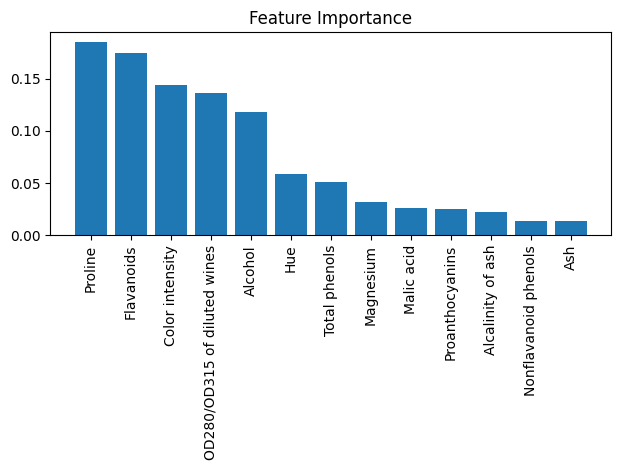

In [120]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[1:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()

plt.show()

# **Selecting Features with an Importance Threshold using SelectFromModel**

In [121]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True) #Lowering the threshold will allow more features that scores above the threshold

X_selected = sfm.transform(X_train)

print('Number of features that meet this threshold', 'criterion:', X_selected.shape[1])

for f in range(X_selected.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,
  feat_labels[indices[f]],
  importances[indices[f]]))

Number of features that meet this threshold criterion: 5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
